In [1]:
!pip install sqlalchemy psycopg2-binary


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Penjelasan Kode

### 1. Import Library
```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Mengimpor library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Mengatur gaya visualisasi agar lebih menarik
sns.set_style('whitegrid')

KeyboardInterrupt: 

## Memuat Data





In [34]:
import pandas as pd
from sqlalchemy import create_engine

# --- GANTI INFORMASI DI BAWAH INI ---
db_user = 'postgres'
db_password = '123456789'
db_host = 'localhost'
db_port = '5432'
db_name = 'data_saya'

# TODO: GANTI DENGAN NAMA TABEL YANG BENAR DARI PGADMIN
# Kemungkinan besar, ini hanya perlu diubah menjadi huruf kecil: 'data_saya'
table_name = 'data_saya' 
# ------------------------------------

# Membuat string koneksi (connection string)
db_url = f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'

# Membuat engine koneksi ke database
engine = None
try:
    engine = create_engine(db_url)
    
    # Query SQL untuk mengambil semua data dari tabel
    sql_query = f'SELECT * FROM "{table_name}";' # Menggunakan kutip dua untuk keamanan
    
    # Membaca data dari PostgreSQL ke dalam DataFrame pandas
    df = pd.read_sql(sql_query, engine)
    
    print("✅ Berhasil terhubung dan mengambil data dari PostgreSQL.")
    print("\n5 Baris Data Teratas:")
    display(df.head())

except Exception as e:
    print(f"❌ Gagal mengambil data: {e}")

finally:
    if engine is not None:
        engine.dispose() # Menutup koneksi

✅ Berhasil terhubung dan mengambil data dari PostgreSQL.

5 Baris Data Teratas:


,Rank,Title,Release,Runtime,Rated,Ratings
0,1,The Shawshank Redemption,1994,2h 22m,R,9.3
1,2,The Godfather,1972,2h 55m,R,9.2
2,3,The Dark Knight,2008,2h 32m,PG-13,9.0
3,4,The Godfather Part II,1974,3h 22m,R,9.0
4,5,12 Angry Men,1957,1h 36m,Approved,9.0


## Informasi Dasar dan Tipe Data

In [36]:
# Mendapatkan ringkasan informasi dataset
print("Informasi Dataset:")
df.info()

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Rank     250 non-null    int64  
 1   Title    250 non-null    object 
 2   Release  250 non-null    int64  
 3   Runtime  250 non-null    object 
 4   Rated    250 non-null    object 
 5   Ratings  250 non-null    float64
dtypes: float64(1), int64(2), object(3)
memory usage: 11.8+ KB


## Analisis Kualitas Data (Missing Values)

In [37]:
# Menghitung jumlah missing values di setiap kolom
missing_values = df.isnull().sum()

# Menghitung persentase missing values
percentage_missing = (missing_values / len(df)) * 100

# Membuat DataFrame untuk menampilkan hasilnya
missing_info = pd.DataFrame({'Jumlah Missing': missing_values, 'Persentase (%)': percentage_missing})

# Menampilkan kolom yang memiliki missing values saja
print("Analisis Missing Values:")
missing_info[missing_info['Jumlah Missing'] > 0].sort_values(by='Jumlah Missing', ascending=False)

Analisis Missing Values:


,Jumlah Missing,Persentase (%)


## Pra-pemrosesan Data (Data Cleaning)

In [38]:
# Fungsi untuk mengonversi format runtime ke total menit
def convert_runtime_to_minutes(runtime_str):
    if isinstance(runtime_str, str):
        hours = 0
        minutes = 0
        if 'h' in runtime_str:
            hours = int(runtime_str.split('h')[0])
        if 'm' in runtime_str:
            minutes_part = runtime_str.split('m')[0]
            if 'h' in minutes_part:
                minutes = int(minutes_part.split('h')[1].strip())
            else:
                minutes = int(minutes_part)
        return hours * 60 + minutes
    return None # Mengembalikan None jika bukan string

# Membuat kolom baru 'Runtime_minutes' dengan format numerik
df['Runtime_minutes'] = df['Runtime'].apply(convert_runtime_to_minutes)

# Menampilkan hasil konversi
print("Data setelah konversi kolom 'Runtime':")
df[['Title', 'Runtime', 'Runtime_minutes']].head()

Data setelah konversi kolom 'Runtime':


,Title,Runtime,Runtime_minutes
0,The Shawshank Redemption,2h 22m,142
1,The Godfather,2h 55m,175
2,The Dark Knight,2h 32m,152
3,The Godfather Part II,3h 22m,202
4,12 Angry Men,1h 36m,96


## Statistik Deskriptif

In [39]:
# Menampilkan statistik deskriptif untuk kolom numerik
# 'Rank' mungkin tidak relevan untuk dianalisis distribusinya, jadi bisa kita drop
print("Statistik Deskriptif untuk Kolom Numerik:")
df.describe()

Statistik Deskriptif untuk Kolom Numerik:


,Rank,Release,Ratings,Runtime_minutes
count,250.000000,250.00000,250.000000,250.000000
mean,125.500000,1988.17200,8.310000,129.796000
std,72.312977,25.59631,0.232716,29.942555
min,1.000000,1921.00000,8.000000,45.000000
25%,63.250000,1971.25000,8.100000,108.250000
50%,125.500000,1995.00000,8.200000,127.500000
75%,187.750000,2008.75000,8.400000,146.750000
max,250.000000,2024.00000,9.300000,238.000000


## Analisis Outlier dengan Metode IQR

In [40]:
# Kolom numerik yang akan dianalisis untuk outlier
numerical_cols = ['Release', 'Ratings', 'Runtime_minutes']

print("Analisis Outlier dengan Metode IQR:")
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Mencari outlier
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    
    print(f"\n--- Analisis Kolom: {col} ---")
    print(f"Batas Bawah: {lower_bound:.2f}")
    print(f"Batas Atas: {upper_bound:.2f}")
    print(f"Jumlah Outlier Terdeteksi: {len(outliers)}")
    
    if not outliers.empty:
        print("Contoh Outlier:")
        print(outliers[['Title', col]].head())

Analisis Outlier dengan Metode IQR:

--- Analisis Kolom: Release ---
Batas Bawah: 1915.00
Batas Atas: 2065.00
Jumlah Outlier Terdeteksi: 0

--- Analisis Kolom: Ratings ---
Batas Bawah: 7.65
Batas Atas: 8.85
Jumlah Outlier Terdeteksi: 9
Contoh Outlier:
                      Title  Ratings
0  The Shawshank Redemption      9.3
1             The Godfather      9.2
2           The Dark Knight      9.0
3     The Godfather Part II      9.0
4              12 Angry Men      9.0

--- Analisis Kolom: Runtime_minutes ---
Batas Bawah: 50.50
Batas Atas: 204.50
Jumlah Outlier Terdeteksi: 6
Contoh Outlier:
                           Title  Runtime_minutes
21                 Seven Samurai              207
86   Once Upon a Time in America              229
99            Lawrence of Arabia              227
162           Gone with the Wind              238
182                      Ben-Hur              212


## Visualisasi Outlier dengan Box Plot

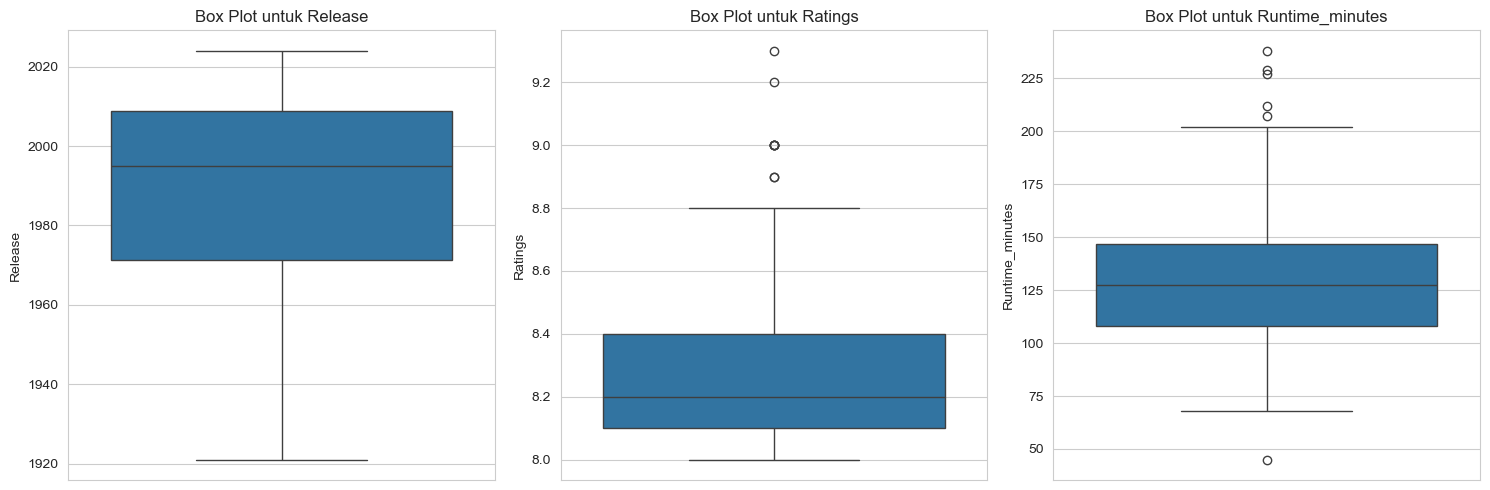

In [41]:
# Membuat Box Plot untuk setiap kolom numerik untuk melihat outlier
plt.figure(figsize=(15, 5))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot untuk {col}')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

## Analisis Konsistensi Data (Kolom Kategorikal)

Distribusi Kategori pada Kolom 'Rated':
Rated
R            101
PG            39
PG-13         35
Not Rated     29
Approved      22
G             18
Passed         5
NC-17          1
Name: count, dtype: int64


C:\Users\user\AppData\Local\Temp\ipykernel_17076\368845606.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['Rated'], order=rated_counts.index, palette='viridis')


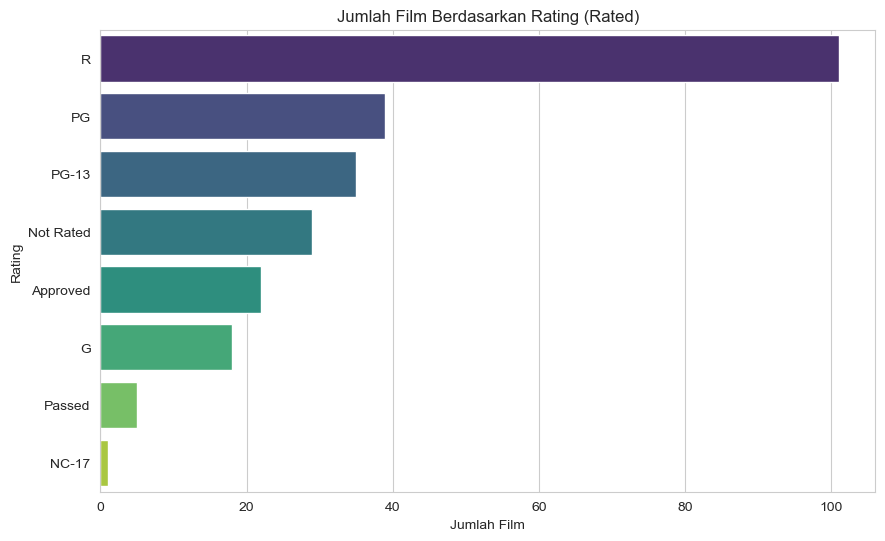

In [42]:
# Memeriksa konsistensi dan distribusi data pada kolom 'Rated'
print("Distribusi Kategori pada Kolom 'Rated':")
rated_counts = df['Rated'].value_counts()
print(rated_counts)

# Visualisasi distribusi kolom 'Rated'
plt.figure(figsize=(10, 6))
sns.countplot(y=df['Rated'], order=rated_counts.index, palette='viridis')
plt.title('Jumlah Film Berdasarkan Rating (Rated)')
plt.xlabel('Jumlah Film')
plt.ylabel('Rating')
plt.show()